In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/AMS2022')

In [3]:
!pip install ekphrasis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 83 kB 1.5 MB/s 
     |████████████████████████████████| 53 kB 1.3 MB/s 


In [4]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['email', 'percent', 'money', 'phone', 'user',
        'time', 'date', 'number'],
    # terms that will be annotated
    #annotate={"hashtag", "allcaps", "elongated", "repeated",'emphasis', 'censored'},
    annotate={"hashtag","allcaps","elongated","repeated",'emphasis','censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading twitter - 1grams ...


/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [5]:
import re
import string 
import pandas as pd
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [6]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AMS2022/Knalpot.csv', sep=',')  

In [7]:
df.head()

,Tweets,cleanedTweets,Translated,Subjectivity,Polarity,Analysis
0,@Almaylifi tercium bau asap knalpot motor racing,tercium bau asap knalpot motor racing,smells of smoke exhaust motor racing,0.00,0.000000,0
1,"@hanajihyo iyaa, besok yang pake knalpot racin...","iyaa, besok yang pake knalpot racing itu aku","Yes, tomorrow I use the racing exhaust",0.00,0.000000,0
2,"Motor bebek pake knalpot racing 75ribu, lewat ...","motor bebek pake knalpot racing 75ribu, lewat ...",Duck motorbike using a 75 thousand racing exha...,0.40,-0.250000,-1
3,@SeputarTetangga Ngebutnya sih gak kenceng tap...,ngebutnya sih gak kenceng tapi kalau suara kn...,"Speed up, it's not fast, but if the sound of a...",0.60,0.133333,1
4,@18fesss Knalpot racing original,knalpot racing original,Original Racing Exhaust,0.75,0.375000,1


In [8]:
del df['cleanedTweets']
del df['Translated']
del df['Subjectivity']
del df['Polarity']

In [9]:
df.head()

,Tweets,Analysis
0,@Almaylifi tercium bau asap knalpot motor racing,0
1,"@hanajihyo iyaa, besok yang pake knalpot racin...",0
2,"Motor bebek pake knalpot racing 75ribu, lewat ...",-1
3,@SeputarTetangga Ngebutnya sih gak kenceng tap...,1
4,@18fesss Knalpot racing original,1


In [10]:
def bersih_data(text):
    return " ".join(text_processor.pre_process_doc(text))

def non_ascii(text):
    return text.encode('ascii', 'replace').decode('ascii')

def remove_space_alzami(text):
    return " ".join(text.split())

def remove_emoji_alzami(text):
    return ' '.join(re.sub("([x#][A-Za-z0-9]+)"," ", text).split())

def remove_tab(text):
    return text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")

def remove_tab2(text):
    return re.sub('\s+',' ',text)

def remove_rt(text):
    return text.replace('RT'," ")

def remove_mention(text):
    return ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())

def remove_incomplete_url(text):
    return text.replace("http://", " ").replace("https://", " ")

def remove_single_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

def change_stripe(text):
    return text.replace('-'," ")

def lower(text):
    return text.lower()

def remove_punctuation(text):
    remove = string.punctuation
    remove = remove.replace("_", "") # don't remove hyphens
    pattern = r"[{}]".format(remove) # create the pattern
    return re.sub(pattern, "", text) 

In [11]:
final_string = []
for text in df['Tweets'].values:
    EachReviewText = ""
    proc = bersih_data(text)
    proc = remove_rt(proc) 
    proc = lower(proc)
    proc = change_stripe(proc)
    proc = remove_tab(proc)
    proc = remove_tab2(proc)
    proc = non_ascii(proc)
    proc = remove_incomplete_url(proc)
    proc = remove_single_char(proc)
    proc = remove_punctuation(proc)
    proc = remove_space_alzami(proc)
    EachReviewText = proc
    final_string.append(EachReviewText)

In [12]:
df["step01"] = final_string

In [13]:
df.head()

,Tweets,Analysis,step01
0,@Almaylifi tercium bau asap knalpot motor racing,0,user tercium bau asap knalpot motor racing
1,"@hanajihyo iyaa, besok yang pake knalpot racin...",0,user iyaa besok yang pake knalpot racing itu aku
2,"Motor bebek pake knalpot racing 75ribu, lewat ...",-1,motor bebek pake knalpot racing 7 5 ribu lewat...
3,@SeputarTetangga Ngebutnya sih gak kenceng tap...,1,user ngebutnya sih gak kenceng tapi kalau suar...
4,@18fesss Knalpot racing original,1,user knalpot racing original


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Tweets    100 non-null    object
 1   Analysis  100 non-null    int64 
 2   step01    100 non-null    object
dtypes: int64(1), object(2)
memory usage: 2.5+ KB


In [15]:
df_hapus = df[~df['step01'].str.contains(" ")]

In [16]:
df_new = df[~df.isin(df_hapus)].dropna()

In [17]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Tweets    100 non-null    object
 1   Analysis  100 non-null    int64 
 2   step01    100 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.1+ KB


In [18]:
# token
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [19]:
def word_tokenize_wrapper(text):
  return word_tokenize(text)

In [20]:
df_new['tokens'] = df['step01'].apply(word_tokenize_wrapper)

In [21]:
df_new.head(10)

,Tweets,Analysis,step01,tokens
0,@Almaylifi tercium bau asap knalpot motor racing,0,user tercium bau asap knalpot motor racing,"[user, tercium, bau, asap, knalpot, motor, rac..."
1,"@hanajihyo iyaa, besok yang pake knalpot racin...",0,user iyaa besok yang pake knalpot racing itu aku,"[user, iyaa, besok, yang, pake, knalpot, racin..."
2,"Motor bebek pake knalpot racing 75ribu, lewat ...",-1,motor bebek pake knalpot racing 7 5 ribu lewat...,"[motor, bebek, pake, knalpot, racing, 7, 5, ri..."
3,@SeputarTetangga Ngebutnya sih gak kenceng tap...,1,user ngebutnya sih gak kenceng tapi kalau suar...,"[user, ngebutnya, sih, gak, kenceng, tapi, kal..."
4,@18fesss Knalpot racing original,1,user knalpot racing original,"[user, knalpot, racing, original]"
5,NJING JAMET BANGET LO. PASTI KALAU NAIK MOTOR ...,1,allcaps njing jamet banget lo allcaps allcaps ...,"[allcaps, njing, jamet, banget, lo, allcaps, a..."
6,Pekain saja dengan pekajaman \n\nReady bosquee...,0,pekain saja dengan pekajaman ready bosque elon...,"[pekain, saja, dengan, pekajaman, ready, bosqu..."
7,Rasanya dah kaya oven apalagi surabaya tuh pan...,1,rasanya dah kaya oven apalagi surabaya tuh pan...,"[rasanya, dah, kaya, oven, apalagi, surabaya, ..."
8,Ie bengkel sebelah loba motor sonic pake knalp...,0,ie bengkel sebelah loba motor sonic pake knalp...,"[ie, bengkel, sebelah, loba, motor, sonic, pak..."
9,"Hujan plus lagu sedih, emang mendukung, sempat...",1,hujan plus lagu sedih emang mendukung sempat d...,"[hujan, plus, lagu, sedih, emang, mendukung, s..."


In [22]:
normalized_word = pd.read_excel("/content/drive/My Drive/Colab Notebooks/AMS2022/kamus perbaikan kata.xlsx")

normalized_word_dict = {}

for index, row in normalized_word.iterrows():
    if row[0] not in normalized_word_dict:
        normalized_word_dict[row[0]] = row[1] 

def normalized_term(document):
    return [normalized_word_dict[term] if term in normalized_word_dict else term for term in document]

df_new['tokens_perbaikan'] = df_new['tokens'].apply(normalized_term)

In [23]:
df_new.head()

,Tweets,Analysis,step01,tokens,tokens_perbaikan
0,@Almaylifi tercium bau asap knalpot motor racing,0,user tercium bau asap knalpot motor racing,"[user, tercium, bau, asap, knalpot, motor, rac...","[user, tercium, bau, asap, knalpot, motor, rac..."
1,"@hanajihyo iyaa, besok yang pake knalpot racin...",0,user iyaa besok yang pake knalpot racing itu aku,"[user, iyaa, besok, yang, pake, knalpot, racin...","[user, iyaa, besok, yang, pakai, knalpot, raci..."
2,"Motor bebek pake knalpot racing 75ribu, lewat ...",-1,motor bebek pake knalpot racing 7 5 ribu lewat...,"[motor, bebek, pake, knalpot, racing, 7, 5, ri...","[motor, bebek, pakai, knalpot, racing, 7, 5, r..."
3,@SeputarTetangga Ngebutnya sih gak kenceng tap...,1,user ngebutnya sih gak kenceng tapi kalau suar...,"[user, ngebutnya, sih, gak, kenceng, tapi, kal...","[user, ngebutnya, sih, tidak, kenceng, tapi, k..."
4,@18fesss Knalpot racing original,1,user knalpot racing original,"[user, knalpot, racing, original]","[user, knalpot, racing, original]"


In [24]:
df_new.iloc[0].tokens

['user', 'tercium', 'bau', 'asap', 'knalpot', 'motor', 'racing']

In [25]:
df_new.iloc[0].tokens_perbaikan

['user', 'tercium', 'bau', 'asap', 'knalpot', 'motor', 'racing']

In [26]:
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [27]:
stopword = nltk.corpus.stopwords.words('indonesian')

def remove_stopwords(text):
  text = [word for word in text if word not in stopword]
  return text

df_new['Stop_removal'] = df_new['tokens_perbaikan'].apply(lambda x: remove_stopwords(x))
df_new

,Tweets,Analysis,step01,tokens,tokens_perbaikan,Stop_removal
0,@Almaylifi tercium bau asap knalpot motor racing,0,user tercium bau asap knalpot motor racing,"[user, tercium, bau, asap, knalpot, motor, rac...","[user, tercium, bau, asap, knalpot, motor, rac...","[user, tercium, bau, asap, knalpot, motor, rac..."
1,"@hanajihyo iyaa, besok yang pake knalpot racin...",0,user iyaa besok yang pake knalpot racing itu aku,"[user, iyaa, besok, yang, pake, knalpot, racin...","[user, iyaa, besok, yang, pakai, knalpot, raci...","[user, iyaa, besok, pakai, knalpot, racing]"
2,"Motor bebek pake knalpot racing 75ribu, lewat ...",-1,motor bebek pake knalpot racing 7 5 ribu lewat...,"[motor, bebek, pake, knalpot, racing, 7, 5, ri...","[motor, bebek, pakai, knalpot, racing, 7, 5, r...","[motor, bebek, pakai, knalpot, racing, 7, 5, r..."
3,@SeputarTetangga Ngebutnya sih gak kenceng tap...,1,user ngebutnya sih gak kenceng tapi kalau suar...,"[user, ngebutnya, sih, gak, kenceng, tapi, kal...","[user, ngebutnya, sih, tidak, kenceng, tapi, k...","[user, ngebutnya, sih, kenceng, suara, knalpot..."
4,@18fesss Knalpot racing original,1,user knalpot racing original,"[user, knalpot, racing, original]","[user, knalpot, racing, original]","[user, knalpot, racing, original]"
...,...,...,...,...,...,...
95,@jek___ tat lu pernah ga pas kentut suaranya k...,1,user tat lu pernah ga pas kentut suaranya kek ...,"[user, tat, lu, pernah, ga, pas, kentut, suara...","[user, tat, kamu, pernah, tidak, cocok, kentut...","[user, tat, cocok, kentut, suaranya, kayak, kn..."
96,Saya menjual knalpot cb150 r face... seharga R...,0,saya menjual knalpot cb150 face repeated sehar...,"[saya, menjual, knalpot, cb150, face, repeated...","[saya, menjual, knalpot, cb150, face, repeated...","[menjual, knalpot, cb150, face, repeated, seha..."
97,Saya menjual knalpot fiz r stainl... seharga R...,0,saya menjual knalpot fiz stainl repeated sehar...,"[saya, menjual, knalpot, fiz, stainl, repeated...","[saya, menjual, knalpot, fiz, stainl, repeated...","[menjual, knalpot, fiz, stainl, repeated, seha..."
98,"@guddayla @cursedkidd gmw,, wili pke knalpot r...",0,user user gmw wili pke knalpot racing,"[user, user, gmw, wili, pke, knalpot, racing]","[user, user, gmw, wili, pakai, knalpot, racing]","[user, user, gmw, wili, pakai, knalpot, racing]"


In [28]:
df_new.iloc[0].tokens_perbaikan

['user', 'tercium', 'bau', 'asap', 'knalpot', 'motor', 'racing']

In [29]:
df_new.iloc[0].Stop_removal

['user', 'tercium', 'bau', 'asap', 'knalpot', 'motor', 'racing']

In [30]:
i=0
final_string_tokens = []
for text in df_new['Stop_removal'].values:
    EachReviewText = ""
    EachReviewText = ' '.join(text)
    final_string_tokens.append(EachReviewText)

In [31]:
df_new["step02"] = final_string_tokens

In [32]:
df_new.head()

,Tweets,Analysis,step01,tokens,tokens_perbaikan,Stop_removal,step02
0,@Almaylifi tercium bau asap knalpot motor racing,0,user tercium bau asap knalpot motor racing,"[user, tercium, bau, asap, knalpot, motor, rac...","[user, tercium, bau, asap, knalpot, motor, rac...","[user, tercium, bau, asap, knalpot, motor, rac...",user tercium bau asap knalpot motor racing
1,"@hanajihyo iyaa, besok yang pake knalpot racin...",0,user iyaa besok yang pake knalpot racing itu aku,"[user, iyaa, besok, yang, pake, knalpot, racin...","[user, iyaa, besok, yang, pakai, knalpot, raci...","[user, iyaa, besok, pakai, knalpot, racing]",user iyaa besok pakai knalpot racing
2,"Motor bebek pake knalpot racing 75ribu, lewat ...",-1,motor bebek pake knalpot racing 7 5 ribu lewat...,"[motor, bebek, pake, knalpot, racing, 7, 5, ri...","[motor, bebek, pakai, knalpot, racing, 7, 5, r...","[motor, bebek, pakai, knalpot, racing, 7, 5, r...",motor bebek pakai knalpot racing 7 5 ribu gang...
3,@SeputarTetangga Ngebutnya sih gak kenceng tap...,1,user ngebutnya sih gak kenceng tapi kalau suar...,"[user, ngebutnya, sih, gak, kenceng, tapi, kal...","[user, ngebutnya, sih, tidak, kenceng, tapi, k...","[user, ngebutnya, sih, kenceng, suara, knalpot...",user ngebutnya sih kenceng suara knalpot mobil...
4,@18fesss Knalpot racing original,1,user knalpot racing original,"[user, knalpot, racing, original]","[user, knalpot, racing, original]","[user, knalpot, racing, original]",user knalpot racing original


In [33]:
!pip install sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 4.3 MB/s 


In [34]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [35]:
final_string = []
s = ""
for sentence in df_new["step02"].values:
    filteredSentence = []
    EachReviewText = ""
    s = (stemmer.stem(sentence))
    filteredSentence.append(s)
    
    EachReviewText = ' '.join(filteredSentence)
    final_string.append(EachReviewText)

In [36]:
df_new["ProcessedText"] = final_string

In [37]:
df_new.head(5)

,Tweets,Analysis,step01,tokens,tokens_perbaikan,Stop_removal,step02,ProcessedText
0,@Almaylifi tercium bau asap knalpot motor racing,0,user tercium bau asap knalpot motor racing,"[user, tercium, bau, asap, knalpot, motor, rac...","[user, tercium, bau, asap, knalpot, motor, rac...","[user, tercium, bau, asap, knalpot, motor, rac...",user tercium bau asap knalpot motor racing,user cium bau asap knalpot motor racing
1,"@hanajihyo iyaa, besok yang pake knalpot racin...",0,user iyaa besok yang pake knalpot racing itu aku,"[user, iyaa, besok, yang, pake, knalpot, racin...","[user, iyaa, besok, yang, pakai, knalpot, raci...","[user, iyaa, besok, pakai, knalpot, racing]",user iyaa besok pakai knalpot racing,user iyaa besok pakai knalpot racing
2,"Motor bebek pake knalpot racing 75ribu, lewat ...",-1,motor bebek pake knalpot racing 7 5 ribu lewat...,"[motor, bebek, pake, knalpot, racing, 7, 5, ri...","[motor, bebek, pakai, knalpot, racing, 7, 5, r...","[motor, bebek, pakai, knalpot, racing, 7, 5, r...",motor bebek pakai knalpot racing 7 5 ribu gang...,motor bebek pakai knalpot racing 7 5 ribu gang...
3,@SeputarTetangga Ngebutnya sih gak kenceng tap...,1,user ngebutnya sih gak kenceng tapi kalau suar...,"[user, ngebutnya, sih, gak, kenceng, tapi, kal...","[user, ngebutnya, sih, tidak, kenceng, tapi, k...","[user, ngebutnya, sih, kenceng, suara, knalpot...",user ngebutnya sih kenceng suara knalpot mobil...,user ngebut sih kenceng suara knalpot mobil ra...
4,@18fesss Knalpot racing original,1,user knalpot racing original,"[user, knalpot, racing, original]","[user, knalpot, racing, original]","[user, knalpot, racing, original]",user knalpot racing original,user knalpot racing original


In [38]:
df_new.to_csv('/content/drive/My Drive/Colab Notebooks/AMS2022/clean_dataset.csv', sep=";")

In [39]:
import pandas as pd
import numpy as np

In [40]:
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AMS2022/clean_dataset.csv', sep=";")

In [41]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        100 non-null    int64 
 1   Tweets            100 non-null    object
 2   Analysis          100 non-null    int64 
 3   step01            100 non-null    object
 4   tokens            100 non-null    object
 5   tokens_perbaikan  100 non-null    object
 6   Stop_removal      100 non-null    object
 7   step02            100 non-null    object
 8   ProcessedText     100 non-null    object
dtypes: int64(2), object(7)
memory usage: 7.2+ KB


In [42]:
dataset_feature = dataset['ProcessedText'].astype(str)

In [43]:
dataset_feature.head(10)

0              user cium bau asap knalpot motor racing
1                 user iyaa besok pakai knalpot racing
2    motor bebek pakai knalpot racing 7 5 ribu gang...
3    user ngebut sih kenceng suara knalpot mobil ra...
4                         user knalpot racing original
5    allcaps njing jamet banget lo allcaps allcaps ...
6    kain pekajaman ready bosque elongated fiz galv...
7    kaya oven surabaya panas ujan tar suara ngalah...
8    ie bengkel belah loba motor sonic pakai knalpo...
9    hujan tambah lagu sedih dukung unggah hapus un...
Name: ProcessedText, dtype: object

In [44]:
dataset_label = dataset['Analysis']

In [45]:
dataset_label.head(10)

0    0
1    0
2   -1
3    1
4    1
5    1
6    0
7    1
8    0
9    1
Name: Analysis, dtype: int64

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


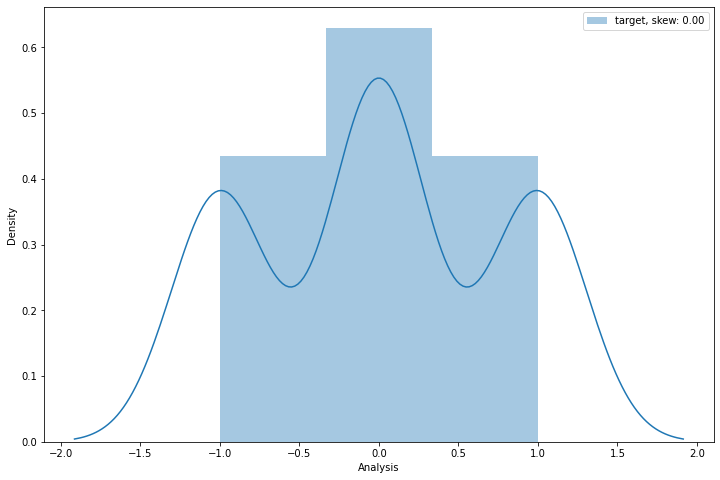

In [47]:
# Visualizing the target variable
plt.figure(figsize=(12,8))
sns.distplot(dataset_label, label=f'target, skew: {dataset_label.skew():.2f}')
plt.legend(loc='best')
plt.show()

In [48]:
dataset_label.value_counts()

 0    42
-1    29
 1    29
Name: Analysis, dtype: int64

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split

In [50]:
train_x, test_x, train_label, test_label = train_test_split(dataset_feature, dataset_label, test_size = 0.2, random_state=42)

In [51]:
test_x

83    jual knalpot racing fulls repeated harga rp955...
53    norak mas mas knalpot racing tuan nyonya mobil...
70          rt user user matic make knalpot racing aneh
45    allcaps stop knalpot racing allcaps user user ...
44    saran knalpot racing bagus merk sih bingung co...
39    update chatan caca number caca putus pacar kay...
22    modif velg tingkat racing number number inch p...
80    bayang pecah jalan kena muka kendara alas anji...
10                            user gara2 knalpot racing
0               user cium bau asap knalpot motor racing
18    allcaps stop knalpot racing allcaps hashtag st...
30    orang tidur ngorok na dengar ngorok kayak knal...
73    user user user user cb video knalpot pakai ori...
33    rt user keren motor pakai knalpot racing norak...
90                        user kayak knalpot racing sih
4                          user knalpot racing original
76                            kerja baik knalpot racing
77    motor bebek pakai knalpot racing 7 5 ribu 

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidf_Vectorizer = TfidfVectorizer() 

In [54]:
from sklearn.naive_bayes import MultinomialNB

In [55]:
from sklearn.pipeline import Pipeline
classifier_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', MultinomialNB()),
])

In [56]:
parameters_nb = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
    'model__alpha': (0.0001, 0.001, 0.1, 1, 10, 100)
}

In [57]:
classifier_nb = GridSearchCV(classifier_nb, parameters_nb, cv = 3, n_jobs=-1)

In [58]:
classifier_nb.fit(train_x, train_label.ravel())

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('model', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'model__alpha': (0.0001, 0.001, 0.1, 1, 10, 100),
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3),
                                                (1, 4)]})

In [59]:
y_pred_nb_train = classifier_nb.predict(train_x)
accuracy_nb_train = accuracy_score(train_label, y_pred_nb_train)
print("Accuracy Training set: ", accuracy_nb_train)

y_pred_nb_test = classifier_nb.predict(test_x)
accuracy_nb_test = accuracy_score(test_label, y_pred_nb_test)
print("Accuracy Test set: ", accuracy_nb_test)

Accuracy Training set:  0.9875
Accuracy Test set:  0.7


In [60]:
recall_nb_train = recall_score(train_label, y_pred_nb_train, average='weighted')
print("Recall Training set: ", recall_nb_train)

recall_nb_test = recall_score(test_label, y_pred_nb_test, average='weighted')
print("Recall Test set: ", recall_nb_test)

Recall Training set:  0.9875
Recall Test set:  0.7


In [61]:
precision_nb_train = precision_score(train_label, y_pred_nb_train, average='weighted')
print("Precision Training set: ", precision_nb_train)

precision_nb_test = precision_score(test_label, y_pred_nb_test, average='weighted')
print("Precision Test set: ", precision_nb_test)

Precision Training set:  0.9878472222222221
Precision Test set:  0.7227272727272727


In [62]:
f1_nb_train = f1_score(train_label, y_pred_nb_train, average='weighted')
print("F1 Training set: ", f1_nb_train)

f1_nb_test = f1_score(test_label, y_pred_nb_test, average='weighted')
print("F1 Test set: ", f1_nb_test)

F1 Training set:  0.9874355891446237
F1 Test set:  0.682936507936508


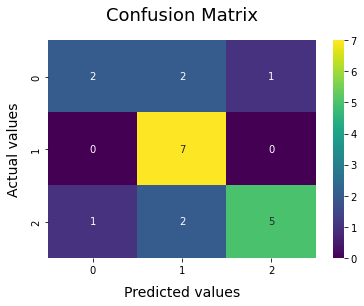

In [63]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_label, y_pred_nb_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

In [64]:
classifier_nb.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('model', MultinomialNB(alpha=0.1))])

In [65]:
for param_name in sorted(parameters_nb.keys()):
    print("%s: %r" % (param_name, classifier_nb.best_params_[param_name]))

model__alpha: 0.1
tfidf__ngram_range: (1, 1)


In [66]:
models = [        
          ('Naive Bayes Multinomial', accuracy_nb_train, accuracy_nb_test),
         ]

In [67]:
predict = pd.DataFrame(data = models, columns=['Model', 'Training Accuracy', 'Test Accuracy'])
predict

,Model,Training Accuracy,Test Accuracy
0,Naive Bayes Multinomial,0.9875,0.7


In [68]:
models_comparison = [                        
                        ('Naive Bayes Multinomial', accuracy_nb_test, recall_nb_test, precision_nb_test, f1_nb_test)                      
                    ]

In [69]:
comparison = pd.DataFrame(data = models_comparison, columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Weighted'])
comparison

,Model,Accuracy,Recall,Precision,F1 Weighted
0,Naive Bayes Multinomial,0.7,0.7,0.722727,0.682937


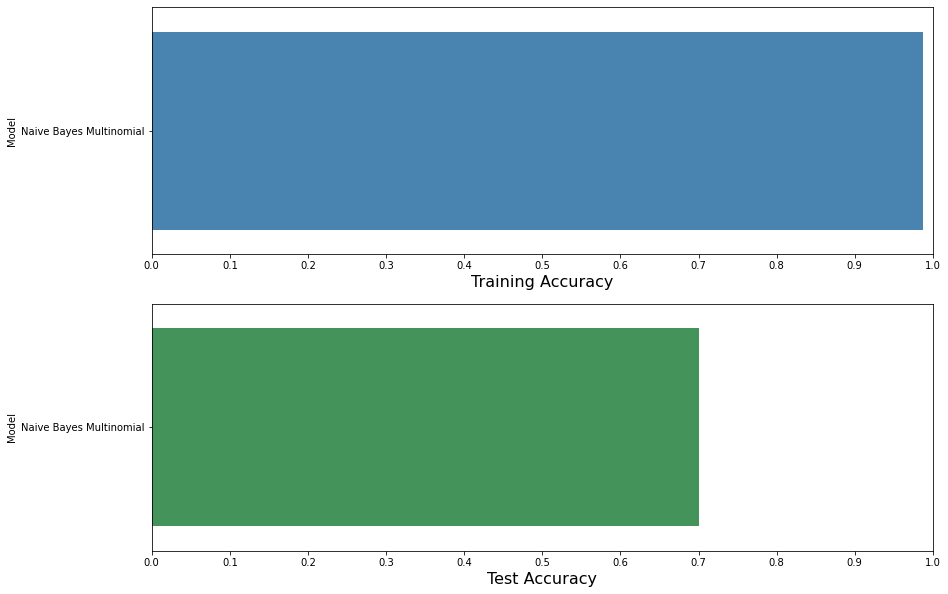

In [70]:
import numpy as np

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['Training Accuracy'], ascending=False, inplace=True)

sns.barplot(x='Training Accuracy', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('Training Accuracy', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)
axes[0].set_xticks(np.arange(0, 1.1, 0.1))

predict.sort_values(by=['Test Accuracy'], ascending=False, inplace=True)

sns.barplot(x='Test Accuracy', y='Model', data = predict, palette='Greens_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('Test Accuracy', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)
axes[1].set_xticks(np.arange(0, 1.1, 0.1))

plt.show()

In [71]:
import joblib

In [72]:
# save the model to disk
filename = '/content/drive/My Drive/Colab Notebooks/AMS2022/classifier_nb.best_estimator_.sav'
joblib.dump(classifier_nb.best_estimator_, filename)

['/content/drive/My Drive/Colab Notebooks/AMS2022/classifier_nb.best_estimator_.sav']